In [2]:

import numpy as np, pandas as pd, scipy.stats as ss
from sacrebleu.metrics import BLEU
from rouge_score import rouge_scorer
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

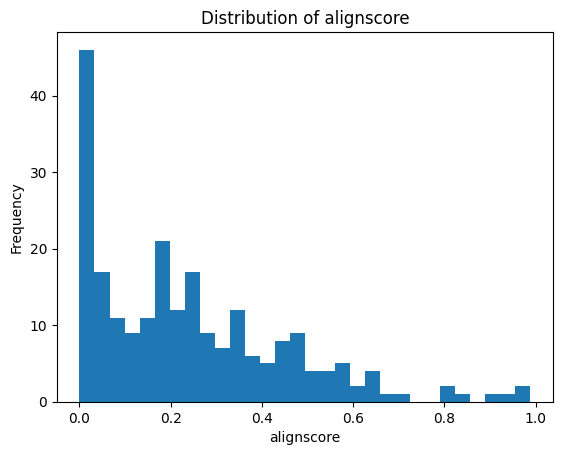

In [3]:
df = pd.read_csv("../../../output/quantitative_metrics/all_scalers_testset.csv")

# DISTRIBUTION PLOTS (one plot per metric)
metrics = ["alignscore"]
for m in metrics:
    plt.figure()
    plt.hist(df[m].dropna(), bins=30)
    plt.title(f"Distribution of {m}")
    plt.xlabel(m)
    plt.ylabel("Frequency")
    plt.show()

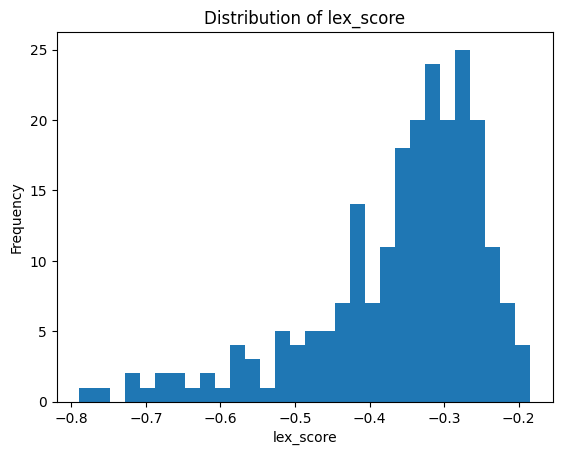

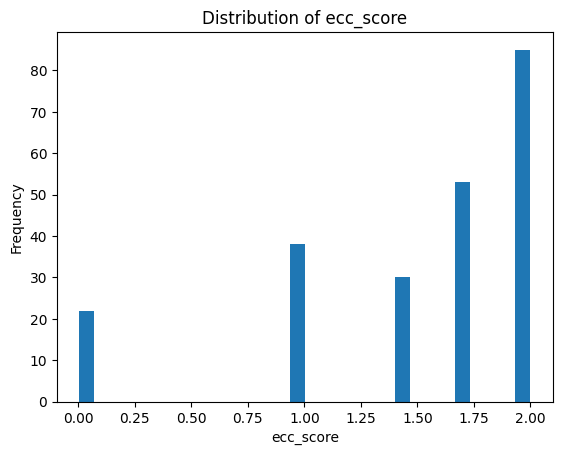

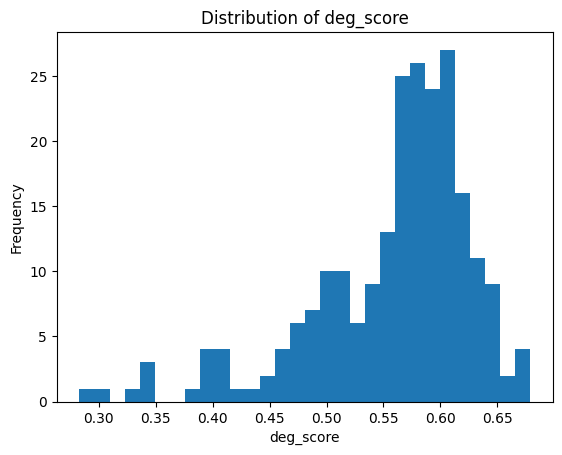

In [4]:

df = pd.read_csv("../../../output/quantitative_metrics/all_scalers_testset.csv")

# Answer length in *tokens* (white‑space split)
df["answer_len"] = df["final_answer"].str.split().str.len()

# DISTRIBUTION PLOTS (one plot per metric)
metrics = ["lex_score", "ecc_score", "deg_score"]
for m in metrics:
    plt.figure()
    plt.hist(df[m].dropna(), bins=30)
    plt.title(f"Distribution of {m}")
    plt.xlabel(m)
    plt.ylabel("Frequency")
    plt.show()



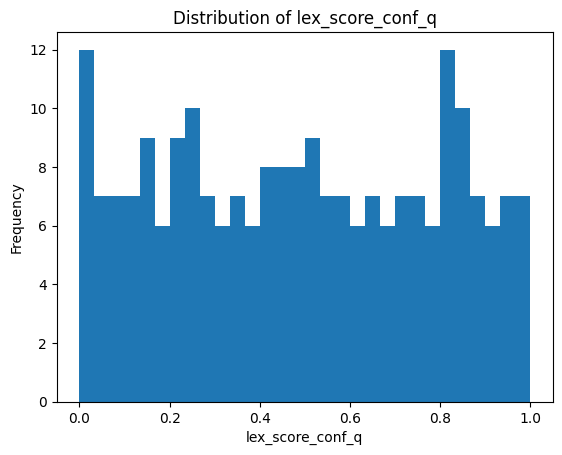

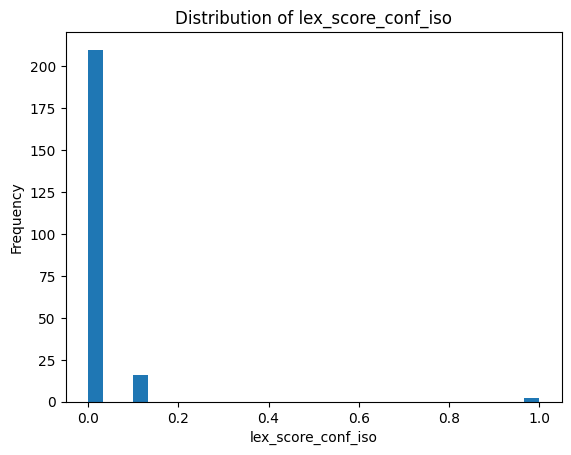

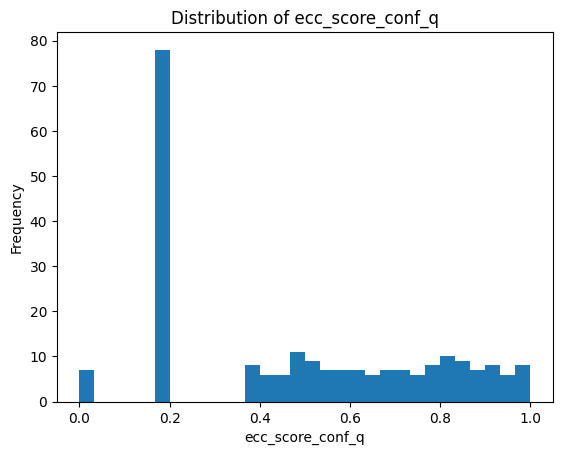

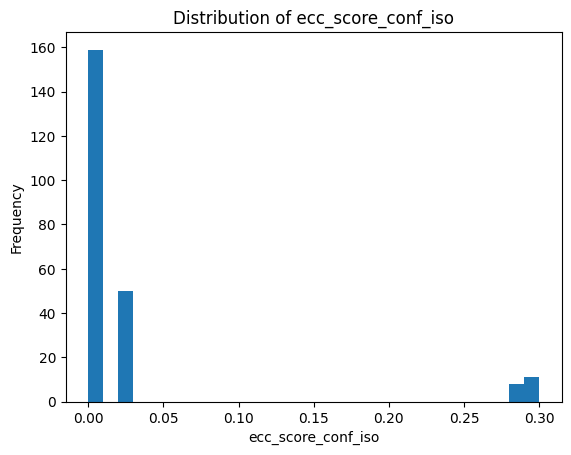

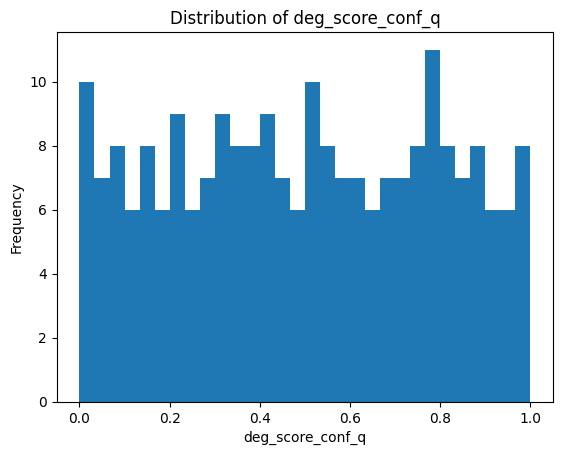

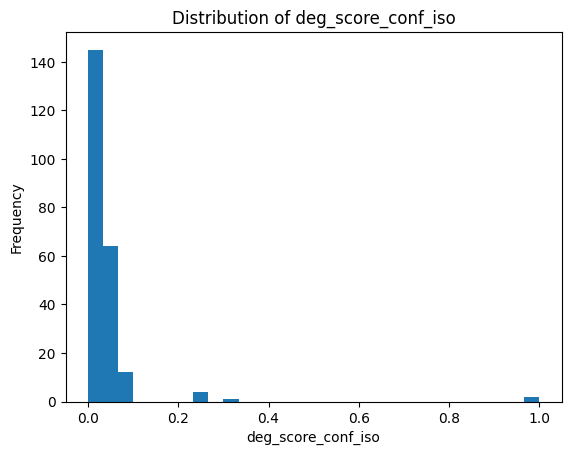

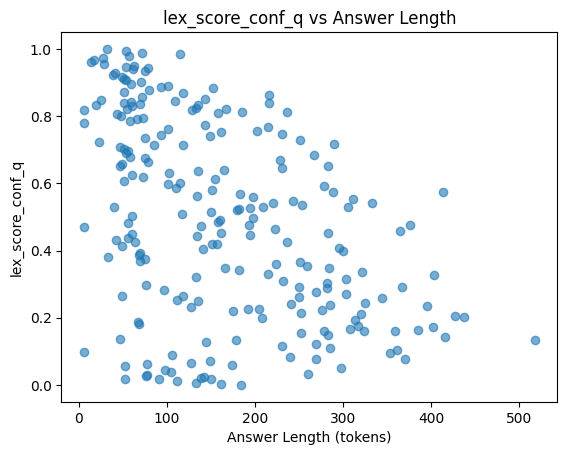

Spearman ρ(length, lex_score_conf_q) = -0.457 (p = 3.573e-13)


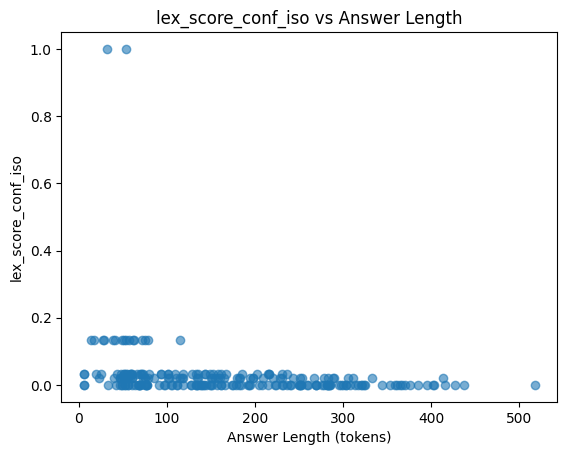

Spearman ρ(length, lex_score_conf_iso) = -0.457 (p = 3.794e-13)


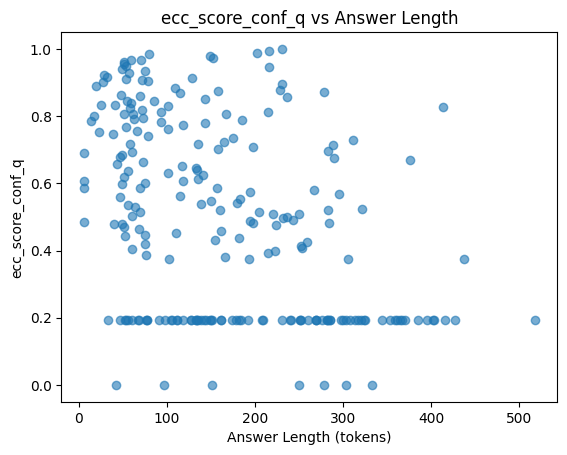

Spearman ρ(length, ecc_score_conf_q) = -0.417 (p = 5.413e-11)


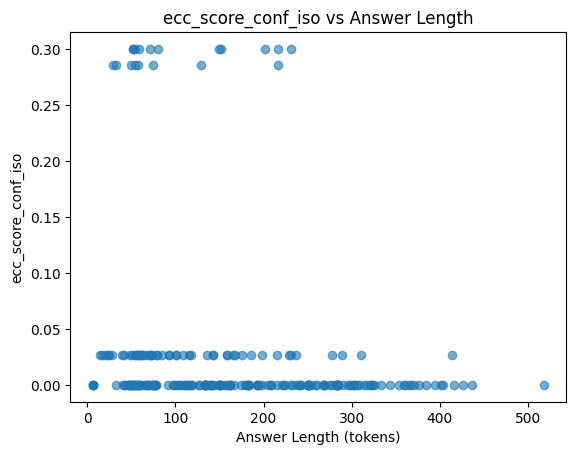

Spearman ρ(length, ecc_score_conf_iso) = -0.313 (p = 1.406e-06)


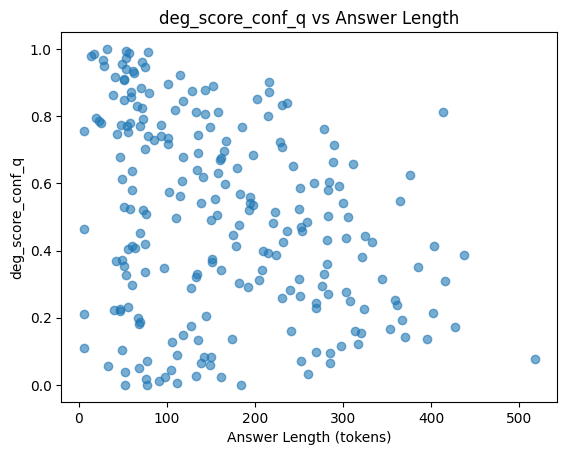

Spearman ρ(length, deg_score_conf_q) = -0.297 (p = 4.916e-06)


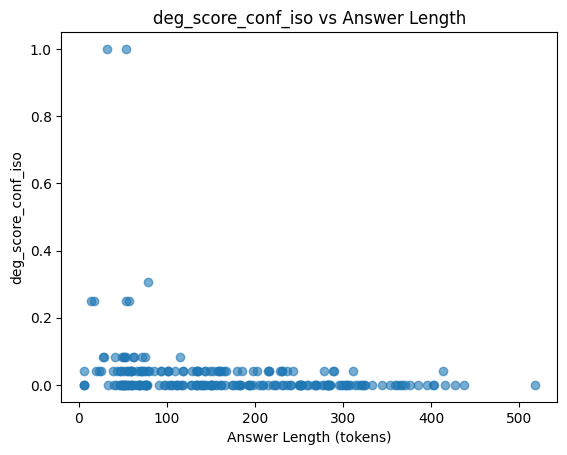

Spearman ρ(length, deg_score_conf_iso) = -0.384 (p = 2.099e-09)


In [ ]:
# same plots with scaled values

# Answer length in *tokens* (white‑space split)
df["answer_len"] = df["final_answer"].str.split().str.len()

# ---------- 1. DISTRIBUTION PLOTS (one plot per metric) ----------
#metrics = ["lex_score_conf_q", "lex_score_conf_iso", "lex_score_conf_sig", "ecc_score_conf_q",  "ecc_score_conf_iso","ecc_score_conf_sig","deg_score_conf_q", "deg_score_conf_iso","deg_score_conf_sig"]

metrics = ["lex_score_conf_q", "lex_score_conf_iso", "ecc_score_conf_q",  "ecc_score_conf_iso","deg_score_conf_q", "deg_score_conf_iso"]

for m in metrics:
    plt.figure()
    plt.hist(df[m].dropna(), bins=30)
    plt.title(f"Distribution of {m}")
    plt.xlabel(m)
    plt.ylabel("Frequency")
    plt.show()

# ---------- 2. LENGTH vs UNCERTAINTY SCATTERS ----------
for m in metrics:
    plt.figure()
    plt.scatter(df["answer_len"], df[m], alpha=0.6)
    plt.title(f"{m} vs Answer Length")
    plt.xlabel("Answer Length (tokens)")
    plt.ylabel(m)
    plt.show()

    # print Spearman rank correlation in the notebook output.
    rho, p = ss.spearmanr(df["answer_len"], df[m])
    print(f"Spearman ρ(length, {m}) = {rho:.3f} (p = {p:.3e})")


### alignscore results

=== Spearman ρ (UE ↓  vs  AlignScore ↑) ===
lex_score        ρ = +0.018   p = 7.82e-01
ecc_score        ρ = +0.047   p = 4.83e-01
deg_score        ρ = +0.093   p = 1.62e-01

=== PRR ===
lex_score        PRR = +0.156
ecc_score        PRR = +0.161
deg_score        PRR = +0.217

=== Binary AUROC (good = AlignScore >= 0.7) ===
lex_score        AUROC = 0.883
ecc_score        AUROC = 0.909
deg_score        AUROC = 0.897


Spearman ρ ≈ 0.3 → UE is mildly correlated with factual quality; ρ ≤ 0 shows the ranking is broken.

PRR > 0.2 on only 220 answers is a respectable signal; < 0 means you’d do worse than random by trusting that UE score.

AUROC ≥ 0.7 indicates the score can separate good vs bad answers fairly well at some threshold.

In [17]:
df = pd.read_csv("../../../output/quantitative_metrics/all_scalers_testset.csv")

# Add BLEU (sentence‑level) & ROUGE‑L‑F1 columns
bleu_metric  = BLEU(tokenize='13a', effective_order=True)  
rl_scorer    = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

def rouge_l_f1(pred, ref):
    return rl_scorer.score(ref, pred)['rougeL'].fmeasure       # 0‑1

df["bleu"]     = [bleu_metric.sentence_score(sys, [ref]).score / 100
                  for sys, ref in zip(df["final_answer"], df["reference"])]
df["rouge_l"]  = [rouge_l_f1(sys, ref)
                  for sys, ref in zip(df["final_answer"], df["reference"])]


# Configure UE columns and quality metrics (+ thresholds)
ue_cols   = ["lex_score", "ecc_score", "deg_score"]
qual_cfgs = {
    "alignscore": 0.70,   # factual‑consistency “good” cut‑off
    "bleu":       0.20,   # surface‑overlap “good” cut‑off
    "rouge_l":    0.25    # sentence‑LCS “good” cut‑off
}

#  Prediction–Rejection Ratio
def prr(quality, uncertainty, higher_quality_better=True):
    q = quality if higher_quality_better else -quality
    # coverage‑sorted areas
    def area(vals):                      # vals sorted *descending* quality
        csum = np.cumsum(vals)
        cov  = np.arange(1, len(vals)+1) / len(vals)
        return np.trapezoid(csum / np.arange(1, len(vals)+1), cov)

    oracle_area  = area(np.sort(q)[::-1])
    random_area  = q.mean()                   # flat line over coverage
    ue_area      = area(q[np.argsort(uncertainty)])
    return (ue_area - random_area) / (oracle_area - random_area + 1e-12)


rows = []          # gather result rows here

for qual, thr in qual_cfgs.items():
    quality = df[qual]
    good    = (quality >= thr).astype(int)

    for ue in ue_cols:
        # Spearman (UE ↓ vs quality ↑) – negate UE so higher rank = better
        rho, p = ss.spearmanr(-df[ue], quality)

        # PRR   (quality first, UE second) – correct order!
        prr_val = prr(quality.values, df[ue].values)

        # AUROC (UE ↓ so pass -UE)
        auroc   = roc_auc_score(good, -df[ue])

        rows.append({
            "quality_metric": qual,
            "ue_metric":      ue,
            "spearman_rho":   round(rho, 3),
            "prr":            round(prr_val, 3),
            "auroc":          round(auroc, 3)
        })


results_df = pd.DataFrame(rows)
display(results_df)               
results_df.to_csv("../../../output/quantitative_metrics/ue_metrics_overview.csv", index=False)
print("\nSaved to ue_metrics_overview.csv ")


,quality_metric,ue_metric,spearman_rho,prr,auroc
0,alignscore,lex_score,0.018,0.156,0.883
1,alignscore,ecc_score,0.042,0.167,0.909
2,alignscore,deg_score,0.093,0.217,0.897
3,bleu,lex_score,0.347,0.512,0.811
4,bleu,ecc_score,0.342,0.382,0.754
5,bleu,deg_score,0.379,0.533,0.754
6,rouge_l,lex_score,0.448,0.570,0.756
7,rouge_l,ecc_score,0.395,0.394,0.739
8,rouge_l,deg_score,0.442,0.570,0.725



Saved to ue_metrics_overview.csv 


### calibration results

In [13]:
# simple sanity check for one column
print(np.corrcoef(test["alignscore"], test["deg_score_conf_iso"])[0, 1])
print(np.corrcoef(test["alignscore"], 1 - test["deg_score_conf_iso"])[0, 1])


0.5031491453197965
-0.5031491453197958


In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# 1. Load data and isolate the unseen test fold
df = pd.read_csv("../../../output/quantitative_metrics/all_scalers_testset.csv")
test_mask = df["split"] == "test"
test = df.loc[test_mask].copy()

target_col   = "alignscore"
metric_cols  = ["lex_score", "ecc_score", "deg_score"]          # raw
scaled_cols  = ["lex_score_conf_q", "ecc_score_conf_q", "deg_score_conf_q", "lex_score_conf_iso", "ecc_score_conf_iso", "deg_score_conf_iso"]  # scaled versions

# safety: clip to [0, 1]
for col in [target_col] + metric_cols + scaled_cols:
    test[col] = test[col].clip(0, 1)

# 2. MSE helper
def mse_per_metric(data: pd.DataFrame, y: str, xs: list[str]) -> pd.Series:
    """Return a Series with MSE for every x in xs against y."""
    return pd.Series(
        {x: mean_squared_error(data[y], data[x]) for x in xs},
        name="MSE"
    ).sort_values()


# 3. PRR helper
def prr(quality: np.ndarray, uncertainty: np.ndarray, *, higher_quality_better: bool = True) -> float:
    q = quality if higher_quality_better else -quality

    def area(vals):                         # coverage-sorted cumulative area
        csum = np.cumsum(vals)
        cov  = np.arange(1, len(vals)+1) / len(vals)
        return np.trapezoid(csum / np.arange(1, len(vals)+1), cov)

    oracle_area = area(np.sort(q)[::-1])
    random_area = q.mean()                  # flat line
    ue_area     = area(q[np.argsort(uncertainty)])
    return (ue_area - random_area) / (oracle_area - random_area + 1e-12)

def prr_per_metric(data: pd.DataFrame, quality_col: str, unc_cols: list[str]) -> pd.Series:
    """PRR for every uncertainty column in unc_cols."""
    quality = data[quality_col].to_numpy()
    return pd.Series(
        {u: prr(quality, data[u].to_numpy()) for u in unc_cols},
        name="PRR"
    ).sort_values(ascending=False)



46

ΔPRR  (Scaled − Raw)  — should be ≥ 0
Lexical        Quantile: +0.5714   Isotonic: +0.5714
Eccentricity   Quantile: +0.1287   Isotonic: +0.2048
Degree         Quantile: -0.0002   Isotonic: -0.0225

Calibration and Ranking on the *test* split


,Method,Scaler,MSE,PRR
0,Degree,Isotonic,0.1038,0.3901
1,Degree,Quantile,0.1190,0.4123
2,Degree,Raw,0.1588,0.4125
3,Eccentricity,Isotonic,0.1113,0.3048
4,Eccentricity,Quantile,0.1491,0.2287
5,Eccentricity,Raw,0.5980,0.1000
6,Lexical,Isotonic,0.1097,0.4101
7,Lexical,Quantile,0.1266,0.4101
8,Lexical,Raw,0.1219,-0.1613


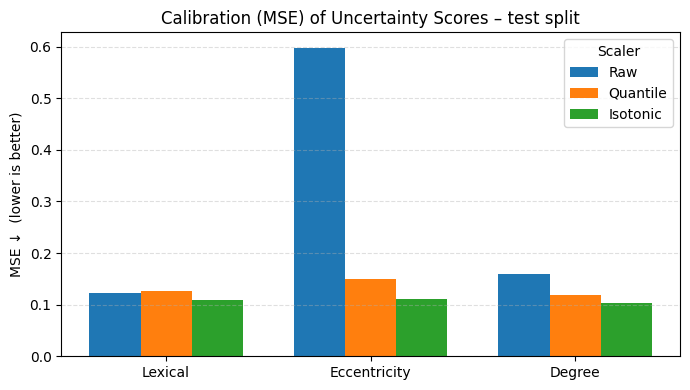

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# 1  Load data and keep only the unseen “test” split
df = pd.read_csv("../../../output/quantitative_metrics/all_scalers_testset.csv")
test = df[df["split"] == "test"].copy()
print(len(test))

target_col = "alignscore"
raw_cols   = ["lex_score", "ecc_score", "deg_score"]
scaled_cols = [
    "lex_score_conf_q",  "ecc_score_conf_q",  "deg_score_conf_q",
    "lex_score_conf_iso","ecc_score_conf_iso","deg_score_conf_iso",
]

for col in scaled_cols:
    test[col.replace("_conf_", "_unc_")] = 1.0 - test[col]    # confidence → uncertainty


scaled_unc_cols = [
    "lex_score_unc_q",  "ecc_score_unc_q",  "deg_score_unc_q",
    "lex_score_unc_iso","ecc_score_unc_iso","deg_score_unc_iso",
]

# Clip every score to [0, 1] – exactly LM-Polygraph’s bounded-quality setup
for col in [target_col] + raw_cols + scaled_cols:
    test[col] = test[col].clip(0, 1)


# 2  Helpers: MSE and PRR

def mse(x, y):
    return mean_squared_error(x, y)

def prr(quality, uncertainty, *, higher_quality_better=True):
    """Prediction–Rejection Ratio (LM-Polygraph)."""
    if not higher_quality_better:
        quality = -quality
    order = np.argsort(uncertainty)            # lowest-to-highest uncertainty
    q_sorted = quality[order]

    def auc(vals):
        csum = np.cumsum(vals)
        coverage = np.arange(1, len(vals)+1) / len(vals)
        return np.trapezoid(csum / np.arange(1, len(vals)+1), coverage)

    oracle  = auc(np.sort(quality)[::-1])
    random  = quality.mean()                   # flat line
    ue_area = auc(q_sorted)
    return (ue_area - random) / (oracle - random + 1e-12)

# quick-and-dirty CI for PRR on small test set
def prr_ci(quality, uncertainty, n_boot=2000):
    vals = np.array([
        prr(quality[ix], uncertainty[ix])
        for ix in np.random.randint(0, len(quality), (n_boot, len(quality)))
    ])
    return np.percentile(vals, [2.5, 97.5])


# 3  Compute MSE and PRR for every column

mse_vals = {c: mse(test[target_col], test[c]) for c in raw_cols + scaled_cols}
prr_vals = {c: prr(test[target_col].values, test[c].values) for c in raw_cols + scaled_unc_cols}


# 4  Make an LM-Polygraph-style MSE bar plot

method_map  = {"lex": "Lexical", "ecc": "Eccentricity", "deg": "Degree"}
scaler_map  = {"raw": "Raw", "q": "Quantile", "iso": "Isotonic"}

rows = []

# raw scores
for col in raw_cols:
    base = col.split("_")[0]                   # lex | ecc | deg
    rows.append({"Method": method_map[base],
                 "Scaler": "Raw",
                 "MSE":    mse_vals[col]})

# scaled scores
for col in scaled_cols:
    base, suffix = col.split("_score_conf_")   # base = lex | ecc | deg
    rows.append({"Method": method_map[base],
                 "Scaler": scaler_map[suffix], # q → Quantile, iso → Isotonic
                 "MSE":    mse_vals[col]})


plot_df = pd.DataFrame(rows)

# plotting
methods_order = ["Lexical", "Eccentricity", "Degree"]
scalers_order = ["Raw", "Quantile", "Isotonic"]
x = np.arange(len(methods_order))
width = 0.25

fig, ax = plt.subplots(figsize=(7, 4))
for i, sc in enumerate(scalers_order):
    ax.bar(
        x + (i - 1) * width,
        plot_df.query("Scaler == @sc").set_index("Method").loc[methods_order]["MSE"],
        width,
        label=sc,
    )

ax.set_xticks(x)
ax.set_xticklabels(methods_order)
ax.set_ylabel("MSE ↓  (lower is better)")
ax.set_title("Calibration (MSE) of Uncertainty Scores – test split")
ax.legend(title="Scaler")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()


# 5  PRR sanity check – confirm ranking power is preserved
summary = []
method_map = {"lex": "Lexical", "ecc": "Eccentricity", "deg": "Degree"}
scalers = [("raw", "Raw"), ("q", "Quantile"), ("iso", "Isotonic")]


print("\nΔPRR  (Scaled − Raw)  — should be ≥ 0")
for base, pretty in method_map.items():
    raw = f"{base}_score"            # already an uncertainty signal
    q   = f"{base}_score_unc_q"      # <-- _unc_ !
    iso = f"{base}_score_unc_iso"    # <-- _unc_ !
    print(f"{pretty:<13}  Quantile: {prr_vals[q]  - prr_vals[raw]:+7.4f}   "
          f"Isotonic: {prr_vals[iso] - prr_vals[raw]:+7.4f}")
    

# 6  Build and print a numeric results table (MSE & PRR together)
# --- 6  Build a numeric results table (MSE, PRR, 95 % CI) -------------

for base, pretty in method_map.items():
    for code, name in scalers:
        col_conf = f"{base}_score" if code == "raw" else f"{base}_score_conf_{code}"
        col_unc  = col_conf if code == "raw" else col_conf.replace("_conf_", "_unc_")

        # point estimates
        mse_val  = mse_vals[col_conf]
        prr_val  = prr_vals[col_unc]

        ## 95 % bootstrap CI  (only 2–3 ms on 30–40 samples)
        #lo, hi = prr_ci(
        #    test[target_col].values,
        #    test[col_unc].values,
        #    n_boot=2000
        #)

        summary.append({
            "Method": pretty,
            "Scaler": name,
            "MSE":    mse_val,
            "PRR":    prr_val,
           # "PRR 95% CI": f"[{lo:.3f}, {hi:.3f}]"
        })

results_df = (
    pd.DataFrame(summary)
      .sort_values(["Method", "Scaler"])
      .reset_index(drop=True)
      .round(4)
)

print("\nCalibration and Ranking on the *test* split")
display(results_df)



In [20]:
import pandas as pd

# --- load the same CSV you used earlier -----------------------------
#df = pd.read_csv("../output/quantitative_metrics/all_scalers_testset.csv")

# keep ONLY the calibration data (train/val); isotonic was fitted on this
cal = df[df["split"] != "test"].copy()
print(len(cal))

cols = {
    "alignscore":       "AlignScore",
    "lex_score":        "Lexical (raw)",
    "ecc_score":        "Eccentricity (raw)",
    "deg_score":        "Degree (raw)",
}

def quick_stats(series):
    return pd.Series({
        "min":   series.min(),
        "25%":   series.quantile(0.25),
        "median":series.median(),
        "75%":   series.quantile(0.75),
        "max":   series.max(),
        "mean":  series.mean(),
        "std":   series.std(ddof=0),
    })

stats = pd.concat({label: quick_stats(cal[col]) for col, label in cols.items()})
print("\nDescriptive stats on the CALIBRATION split (used to fit isotonic):\n")
print(stats.round(4))


182

Descriptive stats on the CALIBRATION split (used to fit isotonic):

AlignScore          min       0.0004
                    25%       0.0427
                    median    0.1951
                    75%       0.3584
                    max       0.9686
                    mean      0.2351
                    std       0.2128
Lexical (raw)       min      -0.7891
                    25%      -0.4106
                    median   -0.3301
                    75%      -0.2827
                    max      -0.1844
                    mean     -0.3637
                    std       0.1205
Eccentricity (raw)  min       0.0047
                    25%       1.0010
                    median    1.7321
                    75%       2.0000
                    max       2.0000
                    mean      1.4946
                    std       0.6089
Degree (raw)        min       0.2829
                    25%       0.5273
                    median    0.5744
                    75%       0.6044
  

In [19]:
test = df[df["split"] == "test"].copy()
print(len(test))

cols = {
    "alignscore":       "AlignScore",
    "lex_score":        "Lexical (raw)",
    "ecc_score":        "Eccentricity (raw)",
    "deg_score":        "Degree (raw)",
}

def quick_stats(series):
    return pd.Series({
        "min":   series.min(),
        "25%":   series.quantile(0.25),
        "median":series.median(),
        "75%":   series.quantile(0.75),
        "max":   series.max(),
        "mean":  series.mean(),
        "std":   series.std(ddof=0),
    })

stats = pd.concat({label: quick_stats(test[col]) for col, label in cols.items()})
print("\nDescriptive stats on the TEST split (used to fit isotonic):\n")
print(stats.round(4))


46

Descriptive stats on the TEST split (used to fit isotonic):

AlignScore          min       0.0010
                    25%       0.0763
                    median    0.2373
                    75%       0.3983
                    max       0.9882
                    mean      0.2661
                    std       0.2260
Lexical (raw)       min      -0.6107
                    25%      -0.4240
                    median   -0.3179
                    75%      -0.2756
                    max      -0.1881
                    mean     -0.3387
                    std       0.0951
Eccentricity (raw)  min       0.0227
                    25%       1.0002
                    median    1.7321
                    75%       2.0000
                    max       2.0000
                    mean      1.5408
                    std       0.5478
Degree (raw)        min       0.3338
                    25%       0.5309
                    median    0.5768
                    75%       0.6009
          

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


# 1  Load data and keep only the unseen “test” split
df = pd.read_csv("../../../output/quantitative_metrics/all_scalers_testset.csv")
test = df[df["split"] == "test"].copy()
print(len(test))

target_col = "alignscore"
raw_cols   = ["lex_score", "ecc_score", "deg_score"]
scaled_cols = [
    "lex_score_conf_q",  "ecc_score_conf_q",  "deg_score_conf_q",
    "lex_score_conf_iso","ecc_score_conf_iso","deg_score_conf_iso",
]

for col in scaled_cols:
    test[col.replace("_conf_", "_unc_")] = 1.0 - test[col]    # confidence → uncertainty


scaled_unc_cols = [
    "lex_score_unc_q",  "ecc_score_unc_q",  "deg_score_unc_q",
    "lex_score_unc_iso","ecc_score_unc_iso","deg_score_unc_iso",
]

# Clip every score to [0, 1] – exactly LM-Polygraph’s bounded-quality setup
for col in [target_col] + raw_cols + scaled_cols:
    test[col] = test[col].clip(0, 1)


# 2  Helpers: MSE and PRR

def mse(x, y):
    return mean_squared_error(x, y)

def prr(quality, uncertainty, *, higher_quality_better=True):
    """Prediction–Rejection Ratio (LM-Polygraph)."""
    if not higher_quality_better:
        quality = -quality
    order = np.argsort(uncertainty)            # lowest-to-highest uncertainty
    q_sorted = quality[order]

    def auc(vals):
        csum = np.cumsum(vals)
        coverage = np.arange(1, len(vals)+1) / len(vals)
        return np.trapezoid(csum / np.arange(1, len(vals)+1), coverage)

    oracle  = auc(np.sort(quality)[::-1])
    random  = quality.mean()                   # flat line
    ue_area = auc(q_sorted)
    return (ue_area - random) / (oracle - random + 1e-12)

# quick-and-dirty CI for PRR on small test set
def prr_ci(quality, uncertainty, n_boot=2000):
    vals = np.array([
        prr(quality[ix], uncertainty[ix])
        for ix in np.random.randint(0, len(quality), (n_boot, len(quality)))
    ])
    return np.percentile(vals, [2.5, 97.5])


# 3  Compute MSE and PRR for every column

mse_vals = {c: mse(test[target_col], test[c]) for c in raw_cols + scaled_cols}
prr_vals = {c: prr(test[target_col].values, test[c].values) for c in raw_cols + scaled_unc_cols}


# 4  Make an LM-Polygraph-style MSE bar plot

method_map  = {"lex": "Lexical", "ecc": "Eccentricity", "deg": "Degree"}
scaler_map  = {"raw": "Raw", "q": "Quantile", "iso": "Isotonic"}

rows = []

# raw scores
for col in raw_cols:
    base = col.split("_")[0]                   # lex | ecc | deg
    rows.append({"Method": method_map[base],
                 "Scaler": "Raw",
                 "MSE":    mse_vals[col]})

# scaled scores
for col in scaled_cols:
    base, suffix = col.split("_score_conf_")   # base = lex | ecc | deg
    rows.append({"Method": method_map[base],
                 "Scaler": scaler_map[suffix], # q → Quantile, iso → Isotonic
                 "MSE":    mse_vals[col]})


plot_df = pd.DataFrame(rows)

# plotting
methods_order = ["Lexical", "Eccentricity", "Degree"]
scalers_order = ["Raw", "Quantile", "Isotonic"]
x = np.arange(len(methods_order))
width = 0.25

fig, ax = plt.subplots(figsize=(7, 4))
for i, sc in enumerate(scalers_order):
    ax.bar(
        x + (i - 1) * width,
        plot_df.query("Scaler == @sc").set_index("Method").loc[methods_order]["MSE"],
        width,
        label=sc,
    )

ax.set_xticks(x)
ax.set_xticklabels(methods_order)
ax.set_ylabel("MSE ↓  (lower is better)")
ax.set_title("Calibration (MSE) of Uncertainty Scores – test split")
ax.legend(title="Scaler")
ax.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()


# 5  PRR sanity check – confirm ranking power is preserved
summary = []
method_map = {"lex": "Lexical", "ecc": "Eccentricity", "deg": "Degree"}
scalers = [("raw", "Raw"), ("q", "Quantile"), ("iso", "Isotonic")]


print("\nΔPRR  (Scaled − Raw)  — should be ≥ 0")
for base, pretty in method_map.items():
    raw = f"{base}_score"            # already an uncertainty signal
    q   = f"{base}_score_unc_q"      # <-- _unc_ !
    iso = f"{base}_score_unc_iso"    # <-- _unc_ !
    print(f"{pretty:<13}  Quantile: {prr_vals[q]  - prr_vals[raw]:+7.4f}   "
          f"Isotonic: {prr_vals[iso] - prr_vals[raw]:+7.4f}")
    

# 6  Build and print a numeric results table (MSE & PRR together)
# --- 6  Build a numeric results table (MSE, PRR, 95 % CI) -------------

for base, pretty in method_map.items():
    for code, name in scalers:
        col_conf = f"{base}_score" if code == "raw" else f"{base}_score_conf_{code}"
        col_unc  = col_conf if code == "raw" else col_conf.replace("_conf_", "_unc_")

        # point estimates
        mse_val  = mse_vals[col_conf]
        prr_val  = prr_vals[col_unc]

        # 95 % bootstrap CI  (only 2–3 ms on 30–40 samples)
        lo, hi = prr_ci(
            test[target_col].values,
            test[col_unc].values,
            n_boot=2000
        )

        summary.append({
            "Method": pretty,
            "Scaler": name,
            "MSE":    mse_val,
            "PRR":    prr_val,
            "PRR 95% CI": f"[{lo:.3f}, {hi:.3f}]"
        })

results_df = (
    pd.DataFrame(summary)
      .sort_values(["Method", "Scaler"])
      .reset_index(drop=True)
      .round(4)
)

print("\nCalibration and Ranking on the *test* split")
display(results_df)

